In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from matplotlib import pyplot as plt
%matplotlib inline

In [44]:
# del engine_differences
# del approval_cuts
# del engine_shifts
# del float_round
# del make_group
%run '../code/constants.py'
%run '../code/evaluate.py'
%run '../code/feature_selection.py'

In [3]:
df = pd.read_pickle(path + fin_mod_df)
clf = joblib.load('../outputs/CBB_model.pkl')

In [4]:
df_raw = pd.read_pickle(path + ind_f).loc[
    :, [mongo_id, 'extra_variables.merchant_channel_name']].drop_duplicates(mongo_id)
ids = pd.read_pickle(path + mod_ident)[[mongo_id]]

In [5]:
# need to get extra_variables.merchant_channel_name
X, y = get_x_y(df)

In [6]:
predicted = clf.predict_proba(X)[:,1]
decision_score = X['decision_engine.score.points'].values

In [7]:
df_cuts = pd.DataFrame({'predicted': predicted, 'v4': decision_score, 'y': y, 'ids': np.ravel(ids)})
df_cuts = df_cuts.merge(df_raw, left_on='ids', right_on=mongo_id, how='left').drop(
    [mongo_id, 'ids'], axis=1).rename(columns={'extra_variables.merchant_channel_name': 'channel'})

In [8]:
df_cuts.describe()

predicted            v4            y
count  28263.000000  28263.000000  28263.00000
mean       0.219573      0.151048      0.21958
std        0.070684      0.058851      0.41397
min        0.073685      0.080162      0.00000
25%        0.170386      0.105431      0.00000
50%        0.207071      0.134917      0.00000
75%        0.255739      0.183136      0.00000
max        0.868908      0.449148      1.00000

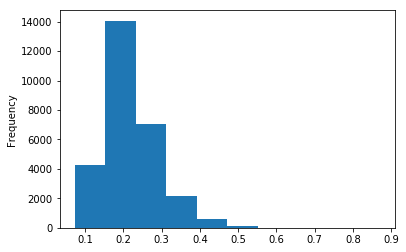

In [9]:
df_cuts.predicted.plot('hist')

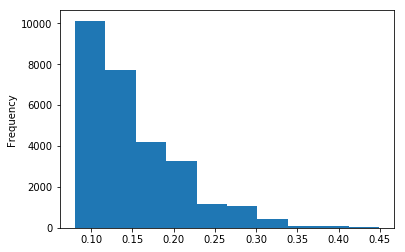

In [10]:
df_cuts.v4.plot('hist')

Get proportion of people who are going to drop out

In [11]:
v4_under18 = df_cuts.v4 < 0.18
print ('number of apps v4 model under 0.18:', np.sum(v4_under18))
pred_under18 = df_cuts.predicted < 0.18
both_under18 = v4_under18 & pred_under18
print ('number of apps both models under 0.18:', np.sum(both_under18))
drop_out = np.sum(v4_under18) - np.sum(both_under18)
print ('number of apps dropping out:', drop_out)
print ('drop out ratio:', drop_out/np.sum(v4_under18))

number of apps v4 model under 0.18: 20849
number of apps both models under 0.18: 8568
number of apps dropping out: 12281
drop out ratio: 0.5890450381313252


Text(0,0.5,'Number of approvals')

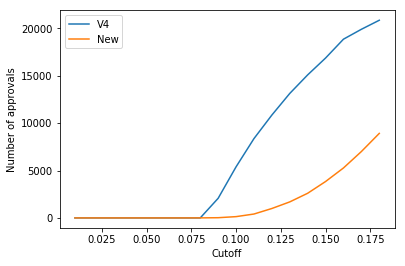

In [12]:
df_diff = engine_differences(df_cuts.v4, df_cuts.predicted)
df_diff.plot(kind='line')
plt.ylabel('Number of approvals')

Get people who v4 determined to be high and new model is not high

In [13]:
v4high = (df_cuts.v4 > 0.16) & (df_cuts.v4 < 0.18)
new_mod_low = (df_cuts.predicted < .16) & v4high
high_to_low_num = np.sum(new_mod_low)
print ("V4 16%-18% predicted probabilities apps: ", np.sum(v4high))
print ("Number transitioned to lower probabilities from V4 high: ", high_to_low_num)
print ('Proportion of high V4 transitioned to low: ', high_to_low_num/np.sum(v4high))

V4 16%-18% predicted probabilities apps:  1997
Number transitioned to lower probabilities from V4 high:  116
Proportion of high V4 transitioned to low:  0.05808713069604406


In [14]:
df_cuts['cut_grp'] = df_cuts.v4.apply(make_group, args=(approval_cuts,))
cuts_grp_df = df_cuts.groupby(['channel', 'cut_grp']).mean()
# cuts_grp_df.to_csv('../outputs/approval_grps.csv')
cuts_grp_df.head(5)

predicted        v4         y
channel   cut_grp                                       
CORE_HIGH <0.095            0.180156  0.088048  0.152778
          >0.095 & <0.108   0.195338  0.101902  0.169231
          >0.108 & <0.12    0.200278  0.113867  0.180328
          >0.12 & <0.132    0.204591  0.125924  0.171875
          >0.132 & <0.144   0.217501  0.138059  0.173913

In [16]:
stores_list = []
for store in df_cuts.channel.unique():
    df_store = df_cuts.loc[df_cuts.channel == store, :]#.sort_values(['channel', 'v4'])
    old, new_model_cutoffs = array_col(df_store.v4.values, approval_cuts, df_store.predicted.values)
    cuts = [str(o) + ', ' + str(n) for o, n in zip(old, new_model_cutoffs)]
    store_df = pd.DataFrame({'old': old, 'new': new_model_cutoffs})
    store_df['channel'] = store
    stores_list.append(store_df)
store_all_df = pd.concat(stores_list)[['channel', 'old', 'new']].set_index('channel')
# print (store_all_df)
# store_all_df.to_csv('../outputs/approval_cuts.csv')

show differences between predicted vs original

In [17]:
diff_df = engine_shifts(df_cuts.v4.values, df_cuts.predicted.values, window=400, cutoff=0.2)

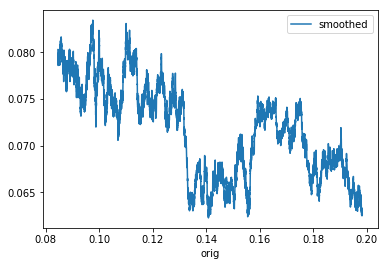

In [18]:
diff_df[['smoothed']].plot(kind='line')

get summary of all apps

In [19]:
df_apps = pd.read_pickle(path + '/' + 'mongo_201711_04.pkl').rename(
    columns={'extra_variables.merchant_channel_name': 'channel'})

In [20]:
df_apps = df_apps.loc[pd.notnull(df_apps.y) & \
                      (df_apps['decision_engine.score.points'] < 0.3), :]

In [21]:
df_apps['score'] = df_apps['decision_engine.score.points'].apply(np.round, args=(2,))
df_apps['score_5'] = df_apps['decision_engine.score.points'].apply(float_round, args=(.05,))
df_apps['score_2'] = df_apps['decision_engine.score.points'].apply(float_round, args=(.02,))


In [22]:
df_grouped = df_apps[['score', 'y']].groupby('score').mean()

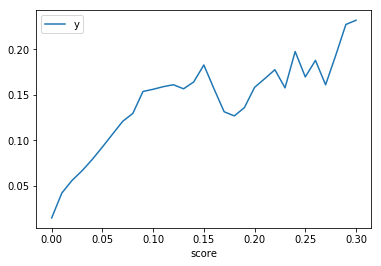

In [23]:
df_grouped.plot(kind='line')

In [24]:
df_grouped5 = df_apps[['score_5', 'y', 'channel']].groupby(['channel', 'score_5']).mean()
# df_grouped5

In [25]:
df_grouped2 = df_apps[['score_2', 'y', 'channel']].groupby(['channel', 'score_2']).agg(
    ['mean', 'count'])
# df_grouped2

In [26]:
# df_grouped2.to_csv('../outputs/channel_v4_defaults.csv')

prediction cuts

In [36]:
def perc_grps(series, splits=0.1, aesc=True):
    """
    """
    series2 = series.sort_index(ascending=aesc)
    chunk = np.int64(series2.size * splits)
    start = 0
    rows = []
    ratio = 0
    while start < series2.size -1:
        name = 'Top ' + str(int(ratio * 100)) + r'% - ' + str(int((ratio + splits) * 100)) + r'%'
        defaults = np.sum(series2.iloc[start:start + chunk])
        cnt = min(start + chunk, series2.size) - start
        # pred_ratio = np.mean(series2.index.values[start:start + chunk])
        pred_ratio = np.mean(series2.index.get_level_values(-1)[start:start + chunk])
        rows.append([name, defaults, cnt, pred_ratio])
        ratio += splits
        start += chunk
    return grps_to_df(rows)

In [47]:
lst_df = []
for chan in df_cuts.channel.unique():
    series = (df_cuts.loc[df_cuts.channel == chan, ['predicted', 'y']]
              .set_index('predicted').y)
    if series.size < 20:
        continue
    chan_df = perc_grps(series, splits=0.05)
    chan_df['channel'] = chan
    lst_df.append(chan_df)
# print ('loop done')
df = pd.concat(lst_df).set_index(['channel', 'Group'])

In [48]:
# cuts_grp_df.to_csv('../outputs/approval_grps.csv')
# store_all_df.to_csv('../outputs/approval_cuts.csv')
# df_grouped2.to_csv('../outputs/channel_v4_defaults.csv')
pdf_to_excel('../outputs', ['app_same', 'v4_cuts', 'v4_grps', 'pred_5']
             , [cuts_grp_df, store_all_df, df_grouped2, df], 'cutoff.xlsx')